# Batch Image Augmentation from Foundations

#### Last Time
We've [just finished](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/09_optimizers_my_reimplementation.ipynb?flush_cache=true) looking at ways we could build more flexible versions of PyTorch's optimizers. Along the way, we took a deep-dive into both weight decay and regularization. 

We investigated how weight decay ought to be properly implemented when [Adam](https://arxiv.org/abs/1412.6980) is used. PyTorch uses SGD's weight decay approach by default, *even with Adam*, and this is not good. We also touched on recent investigations into what is actually happening when weight decay and batchnorm are used together. Though weight decay is clearly exerting some influence on model performance when used in conjunction with batchnorm, we now know that it is not, in fact, regularizing. 

For momentum, we ran through a series of experiments that illustrated how using a dampened, debiased momentum accelerates convergence while enabling subsequent gradient updates to be not unduly influenced by the typically random and unhelpful gradients belonging to the earliest training iterations. 

Finally, we implemented the four main modules necessary to build an Adam optimizer from scratch, and then showed how they could be re-used to easily implement the [LAMB optimizer](https://arxiv.org/abs/1904.00962) from scratch.

#### Data Augmentation
In this notebook we finally get to explore one of the most helpful regularization techniques: data augmentation. At least in the context of image datasets like [Imagenette](https://github.com/fastai/imagenette), data augmentation is nothing more than applying a set of randomly configured image transforms to training inputs *before* these inputs' mini-batches are fed into the model by the data loader. Doing this increases the variety of images that a model is trained on. In other words, data augmentation can be a way to synthesize a larger data set, when no other training samples can be obtained.

Note that while we typically decide ahead of time the particular set of transform algorithms, such as image flips, rotations, or perspective warps, that we will apply to training input images. The parameters of each transform, say the angle by which an image would be rotated, are chosen for each image at random, from within ranges that we pre-specify.

We'll focus solely on image augmentation for the duration of this notebook. The transforms we'll implement are typically useful for ImageNet-like datasets, where most images are side-facing images of objects or people. With other types of imagesets, such as satellite imagery, different kinds of image augmentations may be ideal. The bottom line is that the choice of the set of algorithms used for data augmentation ought to be made after considering any unqiue characteristics of the imageset.

In addition to implementing image transforms from scratch, we'll also zero-in on ways to get these transforms executed as quickly as possible. Since transforms are performed on all of a mini-batch's samples, the ideal approach is to leverage the parallel processing capability of the GPU to simultaneously apply transforms all a batch's images in one fell swoop. Additionally, most image transforms, such as flipping, can be performed much more rapidly on images that are left as byte tensors, as opposed to images that have already been converted to float tensors. 

For this reason, it can be good to hold off on converting images to float tensors until *after* performing all transforms that can be done with bytes. Note that some transforms, such as saturation *cannot* be done as effectively in bytes.

#### PyTorch JIT 
Along the way, we'll be exploring [PyTorch's torch.jit compiler](https://pytorch.org/docs/stable/jit.html) for the first time! JIT's creation was motivated by the desire to allow practitioners to write code in Python that can be translated into a standalone C++ program, with the benefit being that C++ code typically runs faster and is better suited for production deployment than Python code. This is due to Python's performance limitations, such as a lack of multithreading support.

The downside of JIT is that it's currently still in its very early days and tends to be tricky or even at times buggy to work with. We'll see if we can navigate these tradeoffs and nonetheless use JIT to implement some image transforms that run as reliable and faster than their non-JIT counterparts.

#### Attribution
Virtually all the code that appears in this notebook is the creation of [Sylvain Gugger](https://www.fast.ai/about/#sylvain) and [Jeremy Howard](https://www.fast.ai/about/#jeremy). The original version of this notebook that they made for the course lecture can be found [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/10_augmentation.ipynb). I simply re-typed, line-by-line, the pieces of logic necessary to implement the functionality that their notebook demonstrated. In some cases I changed the order of code cells and or variable names so as to fit an organization and style that seemed more intuitive to me. Any and all mistakes are my own.

On the other hand, all long-form text explanations in this notebook are solely my own creation. Writing extensive descriptions of the concepts and code in plain and simple English forces me to make sure that I actually understand how they work.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_09 import *

### Setup
We begin by specifying some initial preprocessing transforms that convert input images to RGB format, to byte tensors, and then finally to float tensors. Converting images to float tensors is necessary for us to be able to ultimately use them as inputs into a deep learning model. 

We'll create an `ImageList()` object that will store the paths to each image in the Imagenette imageset. This object also contains a `tfms` attribute that stores a list of all transformation operations we will apply to our dataset's images.

As we go along, we'll add the new transforms we implement in this notebook to the transforms list. From time to time, we'll replace previously-added transforms with better, more efficient implementations.

In [3]:
#export
imagenette_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette'

In [4]:
# To load in the Imagenette dataset.
path = datasets.untar_data(imagenette_url)

In [5]:
#export

# Ensure that images are first converted to RGB format.
# Uses the RGB transform we created in notebook 08.
MakeRGB()._order = 0

In [6]:
tfms = [MakeRGB(), to_byte_tensor, to_float_tensor]
image_list = ImageList.from_files(path, tfms=tfms)

### PIL Transforms
Back in [notebook 08](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/08_data_block_my_reimplementation.ipynb?flush_cache=true), when we implemented our own version of fastai's [datablock API](https://docs.fast.ai/data_block.html), we made use of the [Pillow library](https://pillow.readthedocs.io/en/stable/index.html) to resize training input images. We'll continue to use it here to implement the following image transform methods.

1. Image resizing
2. Left-right image flips
3. Dihedral image transformations
4. Random image crop and resize
5. Perspective warping

Our dataset will be full-sized [Imagenette](https://github.com/fastai/imagenette) images.

#### Resizing Images

We'll now compare and contrast various Pillow resampling methods that can be used to resize images. We want to pick a method that preserves as much of the original, full-sized image's texture as possible, while still being as speedy as possible.

Here's an original image:

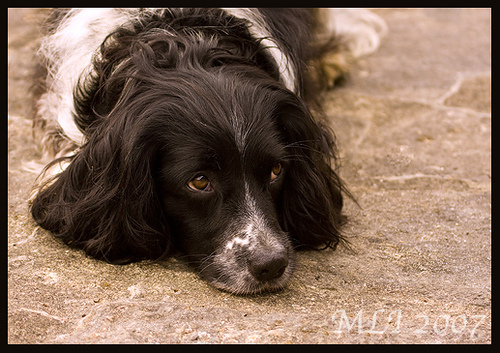

In [7]:
dog_img = PIL.Image.open(image_list.items[9904])
dog_img

We'll compare both the texture preserving abilites and speeds of these Pillow image resampling methods:
1. PIL.Image.ANTIALIAS
2. PIL.Image.BILINEAR
3. PIL.Image.NEAREST
4. PIL.Image.BICUBIC

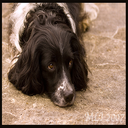

In [8]:
dog_img.resize((128,128), resample=PIL.Image.ANTIALIAS)

In [9]:
%timeit dog_img.resize((128,128), resample=PIL.Image.ANTIALIAS)

2.73 ms ± 853 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


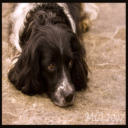

In [10]:
dog_img.resize((128,128), resample=PIL.Image.BILINEAR)

In [11]:
%timeit dog_img.resize((128,128), resample=PIL.Image.BILINEAR)

1.1 ms ± 152 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


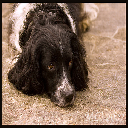

In [12]:
dog_img.resize((128,128), resample=PIL.Image.NEAREST)

In [13]:
%timeit dog_img.resize((128,128), resample=PIL.Image.NEAREST)

28 µs ± 19.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


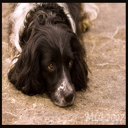

In [14]:
dog_img.resize((128,128), resample=PIL.Image.BICUBIC)

In [15]:
%timeit dog_img.resize((128,128), resample=PIL.Image.BICUBIC)

1.88 ms ± 273 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So far, `PIL.Image.NEAREST` seems to do the best job of preserving texture of the dog's hair and sharpness of the gravel in the image's foreground. Conveniently, this resample method is also the fastest to execute.

There is another resizing approach that offers even better quality, but comes at the expense of a considerable decrease in performance: 

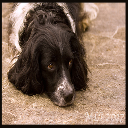

In [16]:
dog_img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

In [17]:
%timeit dog_img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

2.67 ms ± 494 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


Since `PIL.Image.NEAREST` seems to give the best balance between speed and quality, I'll create an improved image resize class that takes advantage of it and add it to our image transform list.

We'll use this to resize all images to 128px by 128px before implementing the image left-right flip transform below.

In [18]:
class BetterResizeFixed(Transform):
    _order = 10
    def __init__(self, size):
        if isinstance(size, int): size = (size, size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.NEAREST)

In [19]:
image_list.tfms.append(BetterResizeFixed(128))

#### Time Budget

Speaking of speed, we're gonna be real concerned with computation speed throughout this entire notebook. The end goal is to implement image transform operations that are as computationally efficient as possible. 

To keep us on the right track, we should devise a time budget! Let's pretend that we're training ImageNet's 1.25 million images from scratch on 8 GPUs. Our budget is to spend no more than 5 minutes preprocessing each epoch's images. This works out to:
* 1,250,000 images / 8 GPUS = 156,250 images per GPU
* 156,250 images / 5 min = 31,250 images per minute per GPU
* 31,250 images / 60 sec = 520 images per second
* Assuming each GPU has 4 cores, 520 images / 4 cores = 125 images per second
* 1 sec / 125 images = 8 milliseconds of time we can spend preprocessing each image per GPU.

We'll round this up to `10ms` and say that the total wall clock time for all image transforms/operations implemented in this notebook must add up to less than this amount! (Note that I assume that this notebook is being run on a machine with only one GPU.)

In order to ascertain whether or not we're on track to meet our goal, we will measure the speed of every single operation that we try out. Let's start by measuring the speed of  PIL's `PIL.Image.open()` method.

I convert the Pillow image to RGB in order to simulate how long it takes to load an image using Pillow and get to the point where it is ready for subsequent image transforms to be performed on it:

In [20]:
make_rgb = MakeRGB()

In [21]:
%timeit test_im = make_rgb(PIL.Image.open(image_list.items[9904]))

5.28 ms ± 6.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Ouch! That's over half of our budget! We'll see that while Pillow can perform most image transforms very quickly, loading images does take time. However, all is not lost. Recall that Pillow performs image transforms, in serial (one image at a time) using the CPU. As I mentioned in this notebook's intro, in the interest of saving time it would make sense to perform image transforms in parallel using the GPU. 

Surprisingly few practitioners' pipelines currently attempt to do this. Later on, after we finish exploring how each image transform works, we'll implement an image rotation transform that can be executed on batches of images on the GPU.

#### Left-Right Image Flip

Pillow is able to perform image flips quite fast.

In [22]:
#export
import random

In [23]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < 0.5 else x

This is the image we'll be working with for the remainder of this notebook. Here is how it appears in its original size and aspect ratio.

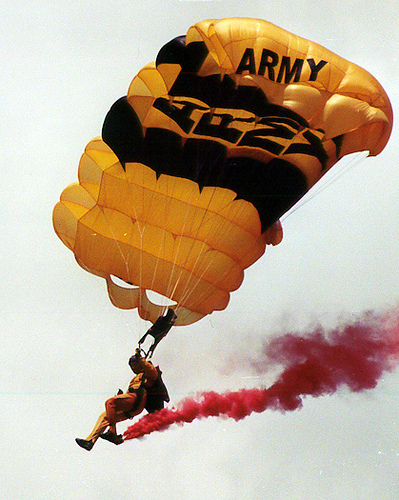

In [24]:
img = PIL.Image.open(image_list.items[0])
img

Our image transforms will be applied with randomly chosen parameters, such as rotation angle. Applying a particular transform to several copies of the same image will help us to have an easier time visualizing the full variety of outcomes that can be produced by each transform operation.

In [25]:
image_list.items = [image_list.items[0]]*64
dl = DataLoader(image_list, 8)
x = next(iter(dl))

Here's a helper function that'll display a batch's images:

In [26]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    # Place channels in tensor's final dimension, if necessary, 
    # so that image can be displayed by matplotlib.
    if im.size(-1) not in [3,4]: im = im.permute(1, 2, 0)
    ax.imshow(im)
    
def show_batch(x, cols=4, rows=None, figsize=None):
    # Put on CPU so that we can plot with matplotlib
    if x.device.type == 'cuda': x = x.cpu()
    n = len(x)
    if rows is None: rows = int(math.ceil(n/cols))
    if figsize is None: figsize = (cols*3, rows*3)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in zip(x, axes.flat): show_image(i, ax)

Here's a batch without random flip augmentation;

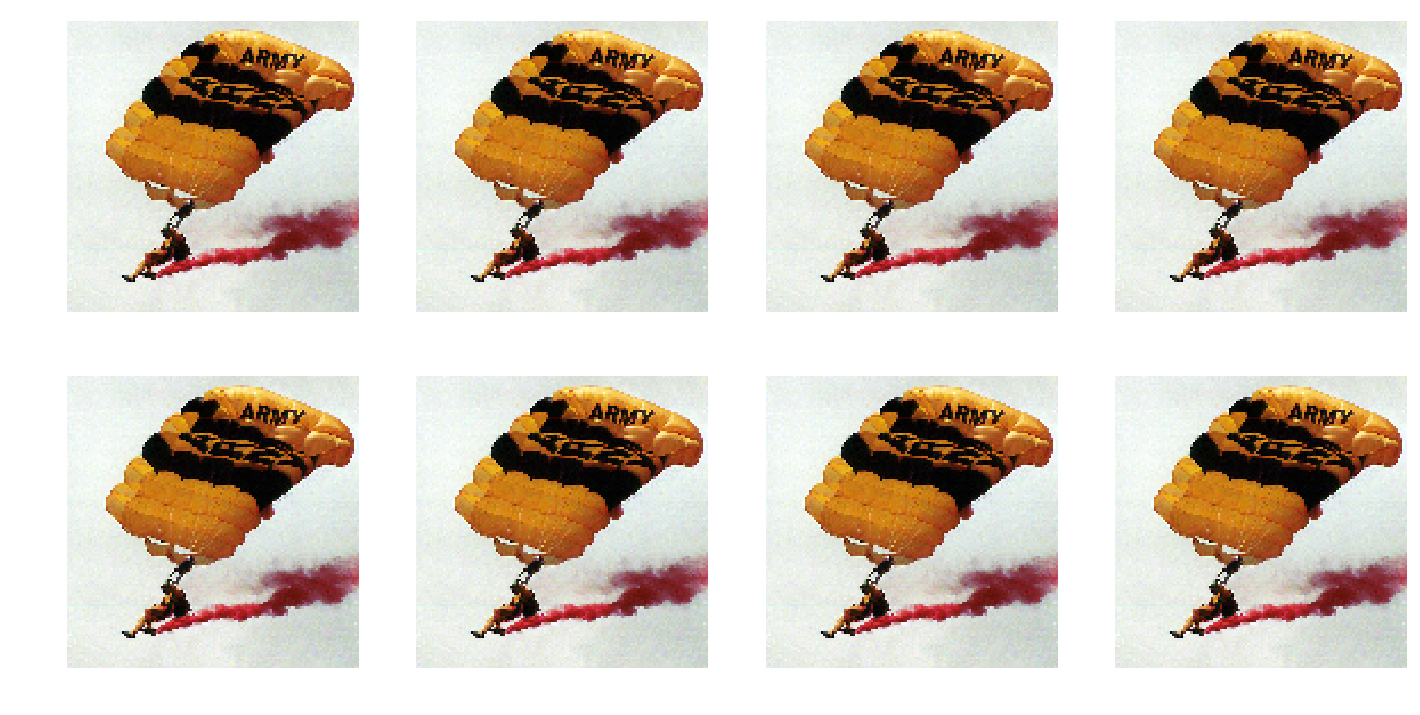

In [27]:
show_batch(x)

And here's a batch with random flip:

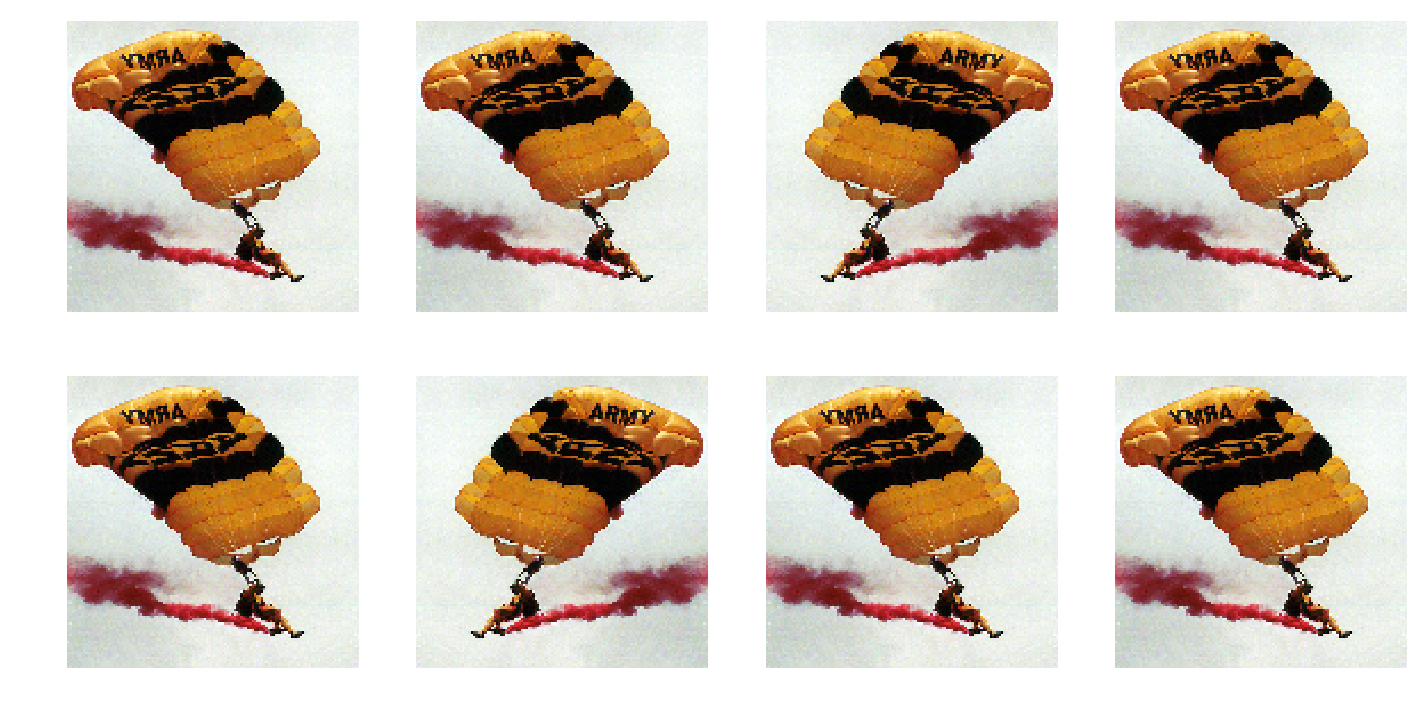

In [28]:
image_list.tfms.append(pil_random_flip)
x = next(iter(dl))
show_batch(x)

Defining our random flip transform as a class will make it easier for us to customize on the fly the probability, `p`, that any input image is flipped. As with previous transform classes, such as `MakeRGB`, we can set the `_order` attribute.

In [29]:
#export
class PilTransform(Transform): _order = 11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

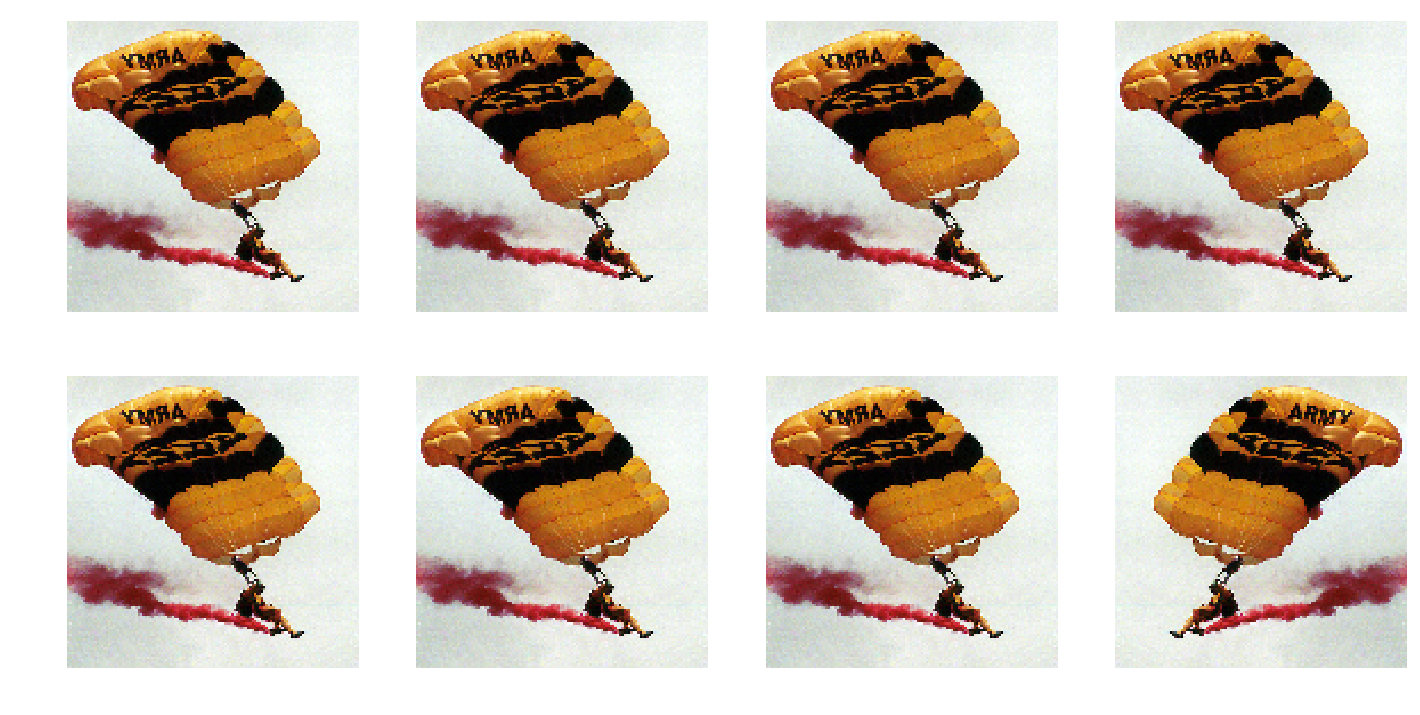

In [30]:
# Replace method implemention of flip transform with class implementation.
del(image_list.tfms[-1])
image_list.tfms.append(PilRandomFlip(0.8))
x = next(iter(dl))
show_batch(x)

In [31]:
rand_flipper = PilRandomFlip(p=0.8)

In [32]:
%timeit rand_flipper(PIL.Image.open(image_list.items[0]))

5.61 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Whoa, that seems really slow! Didn't we state just above that Pillow is really fast at performing image flips? Well, the issue is that we measured the time it took to both open the image and apply the flip. Let's try once more and isolate just the time it takes Pillow to flip the image. 

Also, to get as accurate estimate as possible, we'll also first convert the image to RGB and resize it to 128px by 128px, which is much closer to the size of images that the flip transform will typically be applied to.

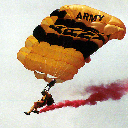

In [33]:
resized_im = make_rgb(PIL.Image.open(image_list.items[0])).resize((128,128), resample=PIL.Image.NEAREST)
resized_im

In [34]:
%timeit -n 1000 rand_flipper(resized_im)

15.1 µs ± 337 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now that's more like it! Notice that I didn't convert image to a float tensor before applying the horizontal flip to it. Pillow is able to perform transforms on images stored on bytes, and as mentioned in above in the intro, transforms on byte images are much faster than transforms on float images.

The moral of the story is: do as many transforms as possible *before* you convert your images to float tensors!

#### Dihedral Image Transforms

Pillow can execute any kind of dihedral image transform:
* horizontal flip
* vertical flip
* rotate 90, 180, or 270 degrees (all rotations are in a counter-clockwise direction)
* transpose flip (equivalent to flipping horizontally, *then* rotating 90 degrees counter-clockwise)
* transverse flip (equivalent to flipping vertically, *then* rotating 90 degrees counter-clockwise)

This makes for a grand total of seven dihedral transforms:

In [35]:
print(PIL.Image.FLIP_LEFT_RIGHT,
      PIL.Image.FLIP_TOP_BOTTOM,
      PIL.Image.ROTATE_90,
      PIL.Image.ROTATE_180,
      PIL.Image.ROTATE_270,
      PIL.Image.TRANSPOSE,
      PIL.Image.TRANSVERSE)

0 1 2 3 4 5 6


We can execute any of this transforms by calling `img.tranpose(<code>)`, where the desired dihedral transform's code (either 0, 1, 2, 3, 4, 5, or 6) is passed to `transpose()`.

However, we must keep in mind that when choosing a random dihedral transform, there are actually **8** possible cases: *either* no dihedral transform is applied, *or* one of the 7 dihedral transforms is chosen.

Below we depict each of these 8 cases. The upper left image has no dihedral transform applied to it. The remaining seven, left to right and top row then bottom row, contain transform codes 0 through 6 applied, in order:

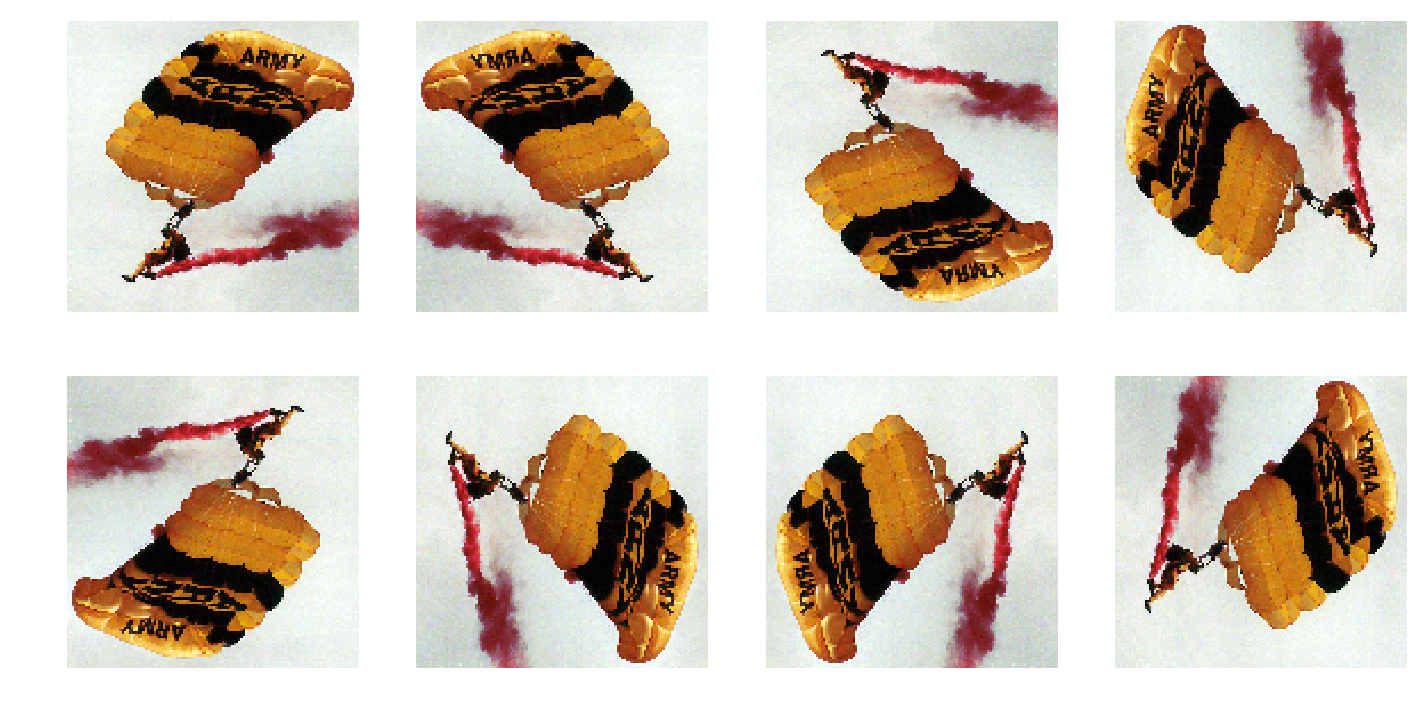

In [36]:
_, axes = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    if i==0: ax.imshow(resized_im)
    else:    ax.imshow(resized_im.transpose(i-1))
    ax.axis('off')

Implementing a random dihedral transfrom class is fairly trivial:

In [37]:
#export
class PilRandomDihedral(PilTransform):
    # Defining self.p = p*7/8 is a useful hack to make it easier
    # for any of the 7 possible dihedral transforms to have precisely 
    # equal chances of being chosen, regardless of what value is 
    # chosen for p. We will always be able to divide the result 
    # of  p * 7/8 into seven different groups, each of the exact 
    # same size. 
    #
    # Moral of the story: no matter what size user picks for p, there
    # will always be an equal chance of choosing any of the 7 dihedral
    # transforms, assuming that the "no transform" option is not first 
    # randomly selected.
    def __init__(self, p=0.75): self.p = p*7/8 
    def __call__(self, x):
        if random.random() > self.p: return x
        return x.transpose(random.randint(0,6))

Since our `PilRandomDihedral` class contains horizontal flips and so much more, let's insert it in our transforms list, replacing `PilRandomFlip`.

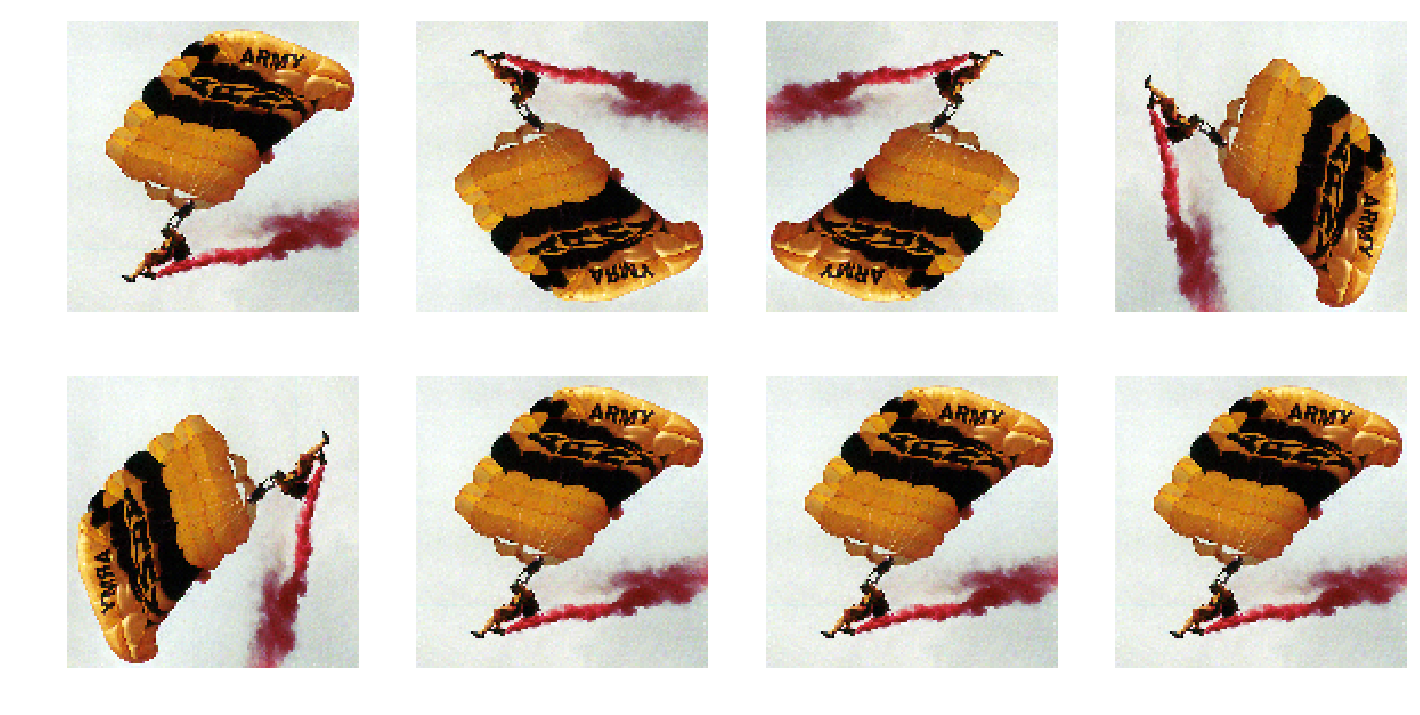

In [38]:
# Replace PilRandomFlip transform with PilRandomDihedral.
del(image_list.tfms[-1])
image_list.tfms.append(PilRandomDihedral())
x = next(iter(dl))
show_batch(x)

In [39]:
rand_dihedral = PilRandomDihedral()

In [40]:
%timeit -n 1000 rand_dihedral(resized_im)

13.8 µs ± 315 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Random Image Crop

In order to crop an image with Pillow we first have to specify the locations of the top-left and bottom-right corners of the crop using this format:
```
(top, left, right, bottom)
```

The order of operations when cropping and resizing image inputs is to first make a crop from the original image, and only then resize to the desired size (say, 128x128).

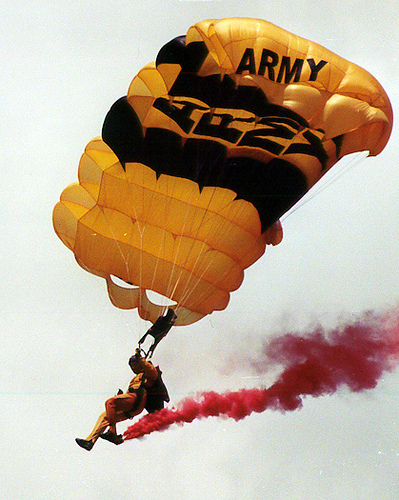

In [41]:
# The original image
img

In [42]:
img.size

(399, 500)

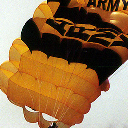

In [43]:
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.NEAREST)

In [44]:
%timeit -n 1000 img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.NEAREST)

60.5 µs ± 284 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We can speed things up by doing the crop and resize in the *same* call to `transform`:

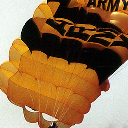

In [45]:
img.transform(size=(128,128), method=PIL.Image.EXTENT, data=(60,60,320,320), resample=PIL.Image.NEAREST)

In [46]:
%timeit -n 1000 img.transform(size=(128,128), method=PIL.Image.EXTENT, data=(20,60,100,200), resample=PIL.Image.NEAREST)

28.4 µs ± 156 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


To implement our crop & resize transform, we'll first write a general crop transform class called `GeneralCrop`, and then add two subclasses:
* The first subclass, `CenterCrop`, will cut out a center crop from the image and then resize. This is how validation set input images need to be preprocessed. 

   What is a "center crop?" Imagine that that we cut away an outer strip of the image's top, left, bottom, and right sides, and each strip has the same width. If we did this we'd then be left with the original image, minus its outer edges. The motivation for this is that the object of interest inside most ImageNet (and Imagenette) images is not located around the images' extreme periphery. In other words, taking away parts of an image that have very little likelihood of being relevant makes it easier to identify the areas of an image that do matter.
   
   
* The second subclass, `RandomResizedCrop`, will perform a random crop from inside each training image, and then resize to the specified size.

In [47]:
#export
from random import randint

# Ensure square-shaped crops are made.
def process_size(size):
    size = listify(size)
    return tuple(size if len(size)==2 else [size[0], size[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.NEAREST):
        self.resample, self.size = resample, process_size(size)
        self.crop_size = None if crop_size is None else process_size(crop_size)
        
    def default_crop_size(self, w, h): return default_crop_size(w,h)
    
    def __call__(self, x):
        if self.crop_size is None: self.crop_size = self.default_crop_size(*x.size)
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *self.crop_size), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)
    
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.NEAREST):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w, h): return [w/self.scale, h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

Every ImageNet competition winner has used random resize & crop as their main augmentation. As such, it's arguably the *most important* augmentation algorithm that we'll implement.

My `RandomResizedCrop` class implements the practices suggested in the 2014 paper, [Going Deeper with Convolutions](https://arxiv.org/abs/1409.4842), authored by Szegedy, et. al.:
1. Select somewhere between 8% to 100% of the image area.
2. Choose a height x width ratio of the crop that is somewhere between 3x4 and 4x3.
3. Then resize this crop to the desired size, say 128px x 128px, for example.

The advantage to this process is that you get a bit of squishing, as well as some zoom, which can both help regularize, at a very low computational cost.

In [48]:
#export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08, 1.0), ratio=(3./4., 4./3.), resample=PIL.Image.NEAREST):
        super().__init__(size, resample=resample)
        self.scale, self.ratio = scale, ratio
        
    def get_corners(self, w, h, wc, hc):
        area = w*h
        
        # Make 10 attempts to randomly select a proper crop from inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            # Generate random number in between 3/4, and 4/3
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            # The following two lines ensure that the ratio of 
            # new_w/new_h is between 3/4 and 4/3, and that 
            # multiplying new_w by new_h would give us our
            # target area.
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            
            # A crop is proper only if the following condition is true.
            if new_w <= w and new_h <=h:
                # Randomly locate the crop's upper-left corner so that 
                # the bottom-right corner is still within the original 
                # image's area.
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
            
        # Fall back to using a simple center crop if we can't auto-
        # generate a successful random crop after ten attempts.
        left, top = randint(0, w-self.crop_size[0]), randit(0, h-self.crop_size[1])
        return(left, top, left+self.crop_size[0], top+self.crop_size[1])

Here's a sample of the kinds of random resized crops that the above class can generate:

In [49]:
image_list.tfms = [MakeRGB(), RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

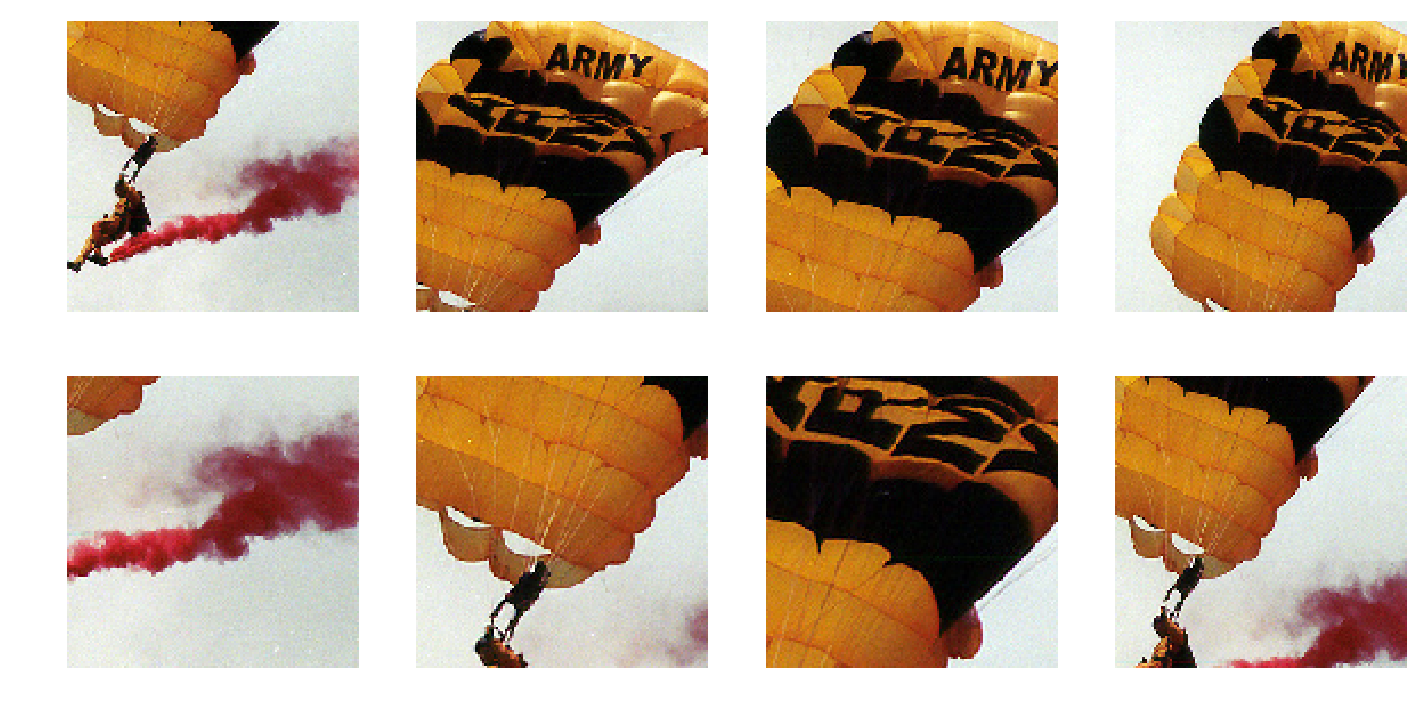

In [50]:
show_batch(next(iter(dl)))

Notice that randomly cropping and resizing according to Szegedy's approach gives my model opportunities to learn about all the different components that make up a parachute, *in detail*! If I had just uniformly resized all images without cropping, my model would never get a chance to learn about a parachute's canopy and strings, as well as the gear worn by a parachuter.

The time taken to apply our random resize crop procedure to one input image falls well within desirable parameters. Since our budget is to use no more than 10 ms to preprocess/transform any individual image, I'd start getting concerned if any individual image operation takes 1 ms or longer.

In [51]:
rand_resized_crop = RandomResizedCrop(size=128)

In [52]:
%timeit -n 1000 rand_resized_crop(img)

45.5 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Perspective Warping

Perspective warping is an operation that takes a flat image and tilts it so as to make it appear that the image is falling either toward or away from you. Imagine that you are holding a photograph in your hand, in such a way that the image's surface is perfectly facing your face. In other words, each of the image's four corners are equally far from your face. Now, applying perspective warping is like using your hand to then tilt this image such that one or more corners are closer to your face than one or more of the image's other corners:

![Perspective Warp Example](images/perspective_warp_ex.gif)
(Above example courtesy of [Linuxtopia.org](https://www.linuxtopia.org/online_books/graphics_tools/gimp_advanced_guide/gimp_guide_node32_011.html))

If you've ever scanned a paper document using a smartphone app and wondered how it is that the scan appears to be perfectly flat and rectangular on your phone's screen, even though your phone may have been tilted when you were capturing the image of the document, perspective warping is the algorithm that makes this kind of transformation possible. Here's a [brief example](https://www.pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/) of how an individual used perspective warping to straighten out a picture he'd taken of his Gameboy's screen.

More technically, the perspective warping algorithm maps the four corners of a rectangular image, that happens to lie in one plane, onto to a new set of four points, which themselves are in another plane:

1. Say we start with a square image that lies in a certain plane. [This paper](https://web.archive.org/web/20150228214510/http://www.robots.ox.ac.uk/~vgg/presentations/bmvc97/criminispaper/node2.html#homographyformula) refers to the image's source plane as the "world plane." In order to perform a perspective transform using this image, we first stretch or squeeze its corners so that we have a 2-d quadrilateral that's a modified version of the original image. 
2. Then we calculate 8 coefficients that define the specific transform that would map the new 2-d quadrilateral onto a rectangle located in another plane, or what [the paper](https://web.archive.org/web/20150228214510/http://www.robots.ox.ac.uk/~vgg/presentations/bmvc97/criminispaper/node2.html#homographyformula) calls the "image plane." Think of the image plane as a window through which we're viewing the world plane. In our case the shape of the rectangle in the output plane, or image plane, will always be a square with an upper-left corner at (0,0).

![Image and World Planes](images/image_world_plane.gif)
(Image from [Antonio Criminisi](https://web.archive.org/web/20150228214510/http://www.robots.ox.ac.uk/~vgg/presentations/bmvc97/criminispaper/node2.html#homographyformula))

For example, if we want to execute a transform that makes it appear that the top edge of a square image is falling towards us, we generate a 2-d quadrilateral by pushing the top-left corner of the original input image inward toward the right and pulling the top-right corner inward toward the left. 

It's crucial to prevent the contents of the warp-transformed image from looking unnaturally squished (remember, we just want to make it look like we're looking at the image from a new perspective, but we *don't* want to make it look like the contents inside image have become squished or stretched). To carry this out, we also stretch the bottom-left corner outward further toward the left and stretch the bottom-right corner outward further toward the right, by the same magnitudes with which we altered the positions of the top-left, and top-right corners, respectively.

Note that the order of corners in the examples below are: 
```
(left,top), (left,bottom), (right,bottom), (right,top)
```
We could actually choose any order we want. The only requirement is that our algorithms always address corners in a consistent order.

To give a concrete example, if we began an image with the following corners:
```
(0,0), (0,200), (100,200), (100,0)
```

If we want to warp its perspective so that it looks like the top of the image is falling toward us, and if we want to display this as a 128px by 128x image, we would morph the image into a 2-d quadrilateral with these new corner coordinates:
```
(30,0), (-30,200), (130,200), (70,0)
```

We then use the coordinates of this 2-d quadrilateral as inputs to compute the values of the perspective transform that would successfully project the 2-d quadrilateral onto a flat 128x128 square with corner coordinates:
```
(0,0), (0,128), (128,128), (128,0)
```

More generally, the following rules govern how we perturb the corners of the source "world" plane's image before we calculate the transform that will project it onto our output "image" plane/window:
1. Width/height coordinates on upper-left and bottom-right corners always move same magnitude in same direction.
2. Same goes for width/height coordinates on upper-right and bottom-left corners. 
3. However, width/height coordinates on upper-left and bottom-left corners move same magnitude but in opposite directions.
4. Same goes for width/height coordinates on upper-right and bottom-right corners.

Pillow's `PIL.Image.PERSPECTIVE` method can execute perspective-warp transforms on images for us, but there are 8 coefficients definining the perspective transform that will first need to be calculated and passed to `PIL.Image.PERSPECTIVE`. These 8 values are the solutions to an equation described at length [in this paper](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/).

Below we define a `find_coefficients()` method below that can solve this equation. It uses PyTorch's `torch.solve` equation solver. Then we make a `warp()` method that uses `PIL.Image.PERSPECTIVE` to perform the actual transform.

In [53]:
#export
from torch import FloatTensor, LongTensor

# Inspired, in part, by mmgp's answer at: 
# https://stackoverflow.com/a/14178717
def find_coefficients(source_coords, output_coords,):
    matrix = []
    for p1, p2 in zip(output_coords, source_coords):
        matrix.append([p1[0], p1[1], 1,     0,     0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([    0,     0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])
        
    # A is a matrix that contains both output, "image," plane and 
    # source, "world," plane coordinates.
    A = FloatTensor(matrix)
    # B is a vector that contains the coordinates located 
    # in the source, "world," plane.
    B = FloatTensor(source_coords).view(8,1)
    
    # The 8 scalars we wish to solve for represent the solution 
    # to x in the equation Ax = B. The solution of x, is the 
    # transform that will map any point in the input (source) 
    # quadrilateral onto a corresponding point in the output plane.
    return list(torch.solve(B, A)[0][:,0])

def warp(image, output_size, source_coords, resample=PIL.Image.NEAREST):
    w,h = output_size
    # Why is the output a rectangle (will be a square in practice)
    # with an upper-left corner at (0,0)? We need to feed square images 
    # into our model.
    output_coords = ((0,0), (0,h), (w,h), (w,0))
    coefficients = find_coefficients(source_coords, output_coords)
    return image.transform(output_size, PIL.Image.PERSPECTIVE, coefficients, resample=resample)

Let's run through a quick test to see how it performs:

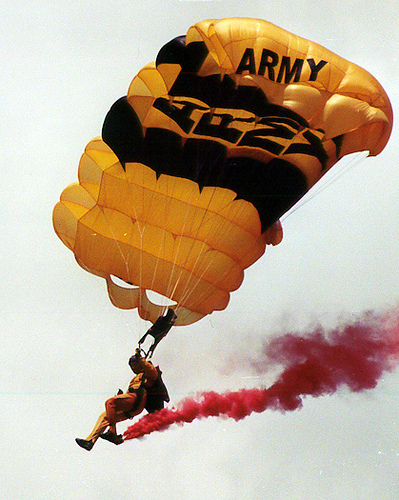

In [54]:
# Original image
img

In [55]:
w, h = img.size
w, h

(399, 500)

Now let's form a 2-d quadrilateral in the shape described in the thoguht exercise above to transform this image such that it'll look like the top of the image is falling toward us:

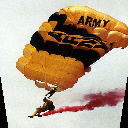

In [56]:
source_coords = ((0+30,0), (0-30,h), (w+30,h), (w-30,0))
warp(img, (128,128), source_coords)

In [57]:
%timeit -n 1000 warp(img, (128,128), source_coords)

275 µs ± 812 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We don't have to just stop at warping images -- we can implement perspective warps in such a way that they resize images as well! 

We'll create a `PilTransform` class that first randomly crops images, and then uses `warp()` to apply a randomly chosen perspective transform that will map the cropped image's points onto the coordinates that are inside a square image on another plane.

In [58]:
#export

# Helper function to generate a random number in between a and b.
def uniform(a,b): return a + (b-a) * random.random()

In [59]:
class PilRandomResizedCropTilt(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST):
        self.resample, self.size, self.magnitude = resample, process_size(size), magnitude
        self.crop_size = None if crop_size is None else process_size(crop_size)
        
    def __call__(self, x):
        if self.crop_size is None: self.crop_size = default_crop_size(*x.size)

        # Generate random multipliers to scale the width 
        # and height of target tilt perspective.
        w_mag = uniform(-self.magnitude, self.magnitude)
        h_mag = uniform(-self.magnitude, self.magnitude)
        
        # Randomly choose the coord of the upper-left corner.
        # Choose such that the crop will be entirely inside 
        # the bounds of the input image.
        left, top = (randint(0, x.size[0] - self.crop_size[0]),
                     randint(0, x.size[1] - self.crop_size[1]))

        # * Width/height coordinates on upper-left and bottom-right 
        #   corners always move same magnitude in same direction.
        #
        # * Same goes for width/height coordinates on upper-right
        #   and bottom-left corners. 
        #
        # * However, width/height coordinates on upper-left and 
        #   bottom-left corners move same magnitude but in opposite 
        #   directions
        #
        # * Same goes for width/height coordinates on upper-right and 
        #   bottom-right corners.
        #
        # The above guidelines prevent image from being squished when 
        # a perspective transform is applied.
        #
        # To understand the matrix below, imagine we begin with a square 
        # at coordinates ((0,0), (0,1), (1,1), (0,1)), and then shift 
        # the width coordinates by w_mag and the height coordinates by 
        # h_mag. In order to stay true to the guidelines listed in the 
        # bullets above, the corner coordinates would have to be 
        # modified in the following manner:
        source_corners = tensor([[ -w_mag,  -h_mag], 
                                 [  w_mag, 1+h_mag],
                                 [1-w_mag, 1-h_mag], 
                                 [1+w_mag,   h_mag]])
        
        # The above matrix represents a sort of "unit square" version of 
        # the randomly generated source quadrilateral. Now we just 
        # scale (enlarge) it so that its area is the same as that of 
        # our crop size, and we locate its position (relative to the 
        # original input image) using the upper-left corner coordinates 
        # that were randomly generated:
        source_corners = source_corners * tensor(self.crop_size).float() + tensor([left,top]).float()

        # Format the four corner coordinates into a tuple.
        source_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in source_corners])
        
        # Now that we have our randomly generated source quadrilateral, 
        # we can solve for, and then execute, the transform that maps 
        # its points onto points in the square image we will use as our 
        # output.
        return warp(x, self.size, source_corners, resample=self.resample)     

Let's give it a try:

In [60]:
image_list.tfms = [MakeRGB(), PilRandomResizedCropTilt(128, magnitude=0.1), 
                 to_byte_tensor, to_float_tensor]

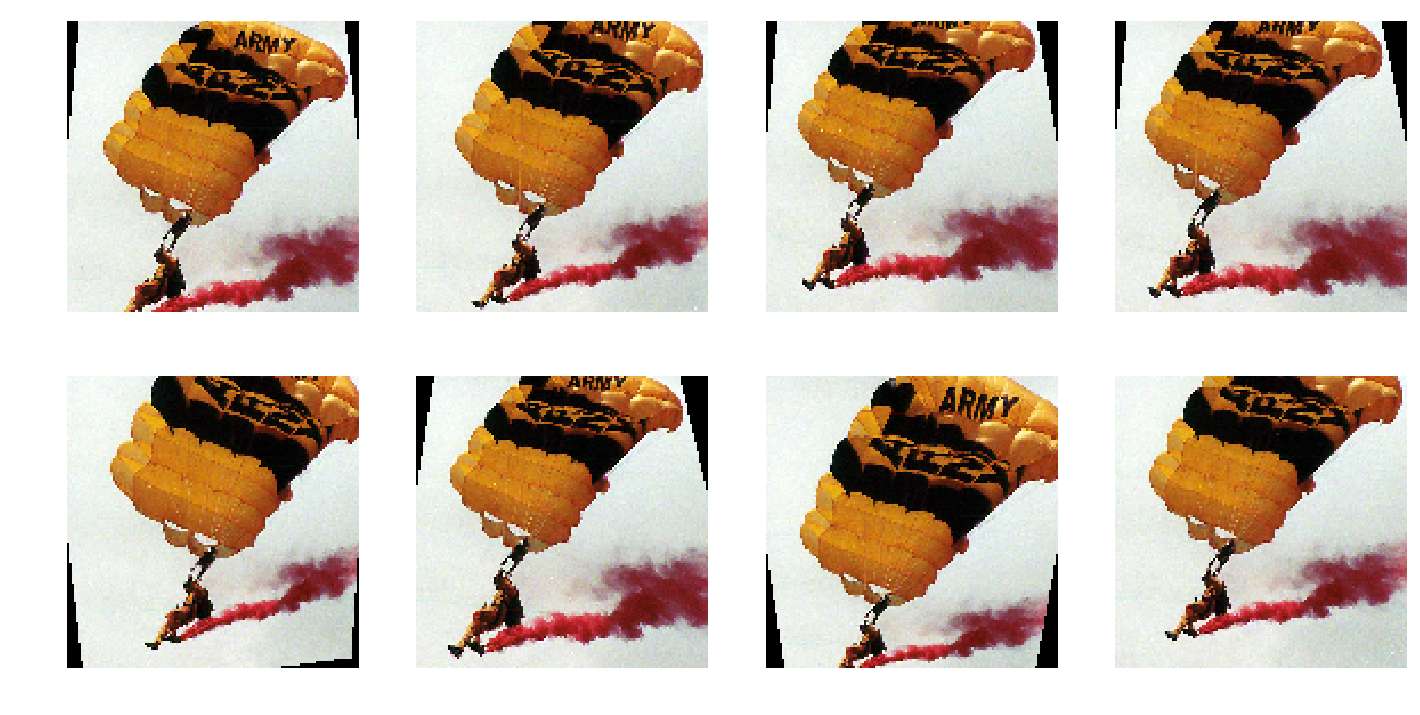

In [61]:
show_batch(next(iter(dl)))

You'll immediately notice that black padding appears in output images where there are points in the output("image") plane that didn't get any points mapped onto them from the perspective-transformed resized random crop in the source/"world" plane. 

We can avoid this by capping magnitude by which we permute the corners of the source image. This will ensure that the output image's corners four corners will always have points from the source image mapped onto them.

In [62]:
#export
class PilRandomResizedCropTilt(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST):
        self.resample, self.size, self.magnitude = resample, process_size(size), magnitude
        self.crop_size = None if crop_size is None else process_size(crop_size)
        
    def __call__(self, x):
        if self.crop_size is None: self.crop_size = default_crop_size(*x.size)
        
        # Randomly choose the coord of the upper-left corner.
        # Choose such that the crop will be entirely inside 
        # the bounds of the input image.
        left, top = (randint(0, x.size[0] - self.crop_size[0]),
                     randint(0, x.size[1] - self.crop_size[1]))
        
        # New in this version: keep magnitude small enough such 
        # that all points in the perspective-transformed output
        # will contain points from the crop.
        w_mag_limit = min(self.magnitude, left/self.crop_size[0], (x.size[0]-left)/self.crop_size[0] - 1)
        h_mag_limit = min(self.magnitude, top /self.crop_size[1], (x.size[1]-top) /self.crop_size[1] - 1)
        
        # Generate random multipliers to scale the width 
        # and height of target tilt perspective.
        w_mag = uniform(-w_mag_limit, w_mag_limit)
        h_mag = uniform(-h_mag_limit, h_mag_limit)
        
        # * Width/height coordinates on upper-left and bottom-right 
        #   corners always move same magnitude in same direction.
        #
        # * Same goes for width/height coordinates on upper-right
        #   and bottom-left corners. 
        #
        # * However, width/height coordinates on upper-left and 
        #   bottom-left corners move same magnitude but in opposite 
        #   directions
        #
        # * Same goes for width/height coordinates on upper-right and 
        #   bottom-right corners.
        #
        # The above guidelines prevent image from being squished when 
        # a perspective transform is applied.
        #
        # To understand the matrix below, imagine we begin with a square 
        # at coordinates ((0,0), (0,1), (1,1), (0,1)), and then shift 
        # the width coordinates by w_mag and the height coordinates by 
        # h_mag. In order to stay true to the guidelines listed in the 
        # bullets above, the corner coordinates would have to be 
        # modified in the following manner:
        source_corners = tensor([[ -w_mag,  -h_mag], 
                                 [  w_mag, 1+h_mag],
                                 [1-w_mag, 1-h_mag], 
                                 [1+w_mag,   h_mag]])
        
        # The above matrix represents a sort of "unit square" version of 
        # the randomly generated source quadrilateral. Now we just 
        # scale (enlarge) it so that its area is the same as that of 
        # or desired crop size, and we locate its position (relative 
        # to the original image) using the upper-left corner coordinates 
        # that were randomly generated:
        source_corners = source_corners * tensor(self.crop_size).float() + tensor([left,top]).float()
        
        # Format the four corner coordinates into a tuple.
        source_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in source_corners])
        
        # Now that we have our randomly generated source quadrilateral, 
        # we can solve for, and then execute, the transform that maps 
        # its points to points in the square image we desire as our 
        # output.
        return warp(x, self.size, source_corners, resample=self.resample)     

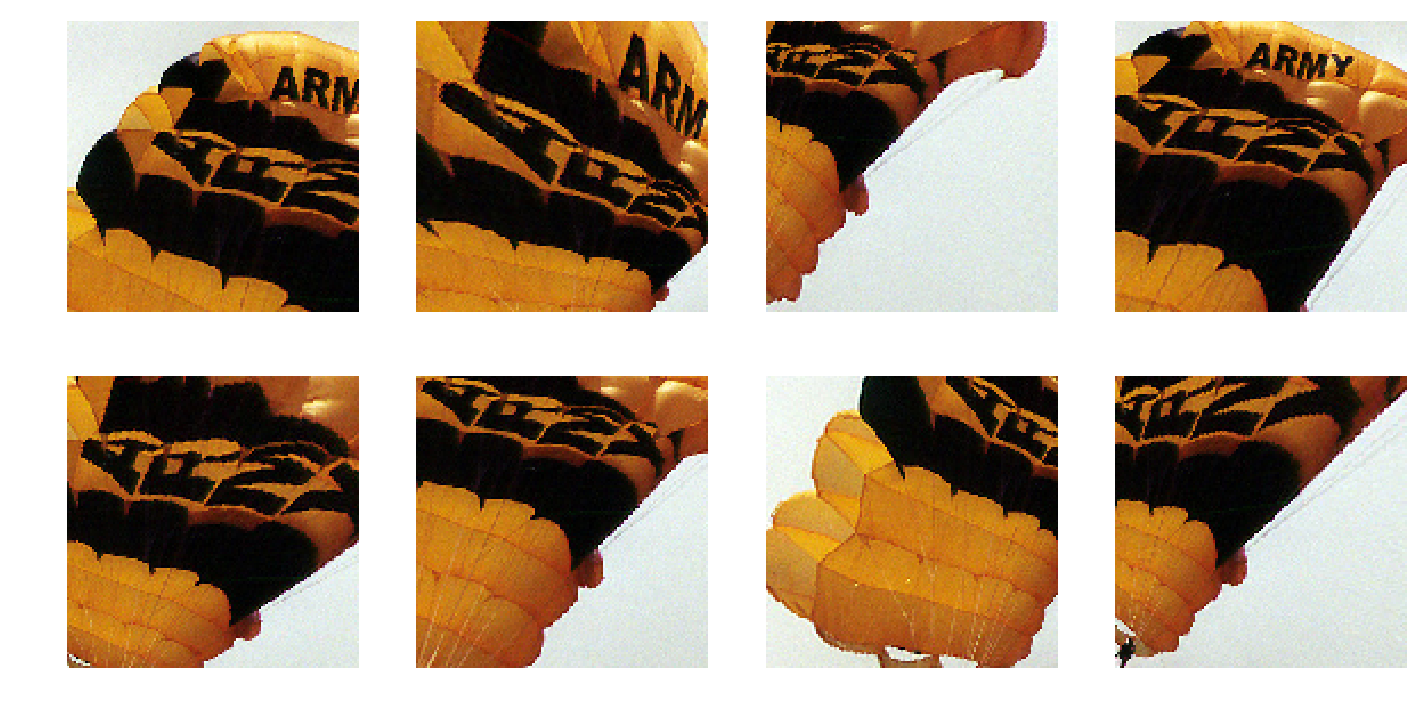

In [63]:
image_list.tfms = [MakeRGB(), PilRandomResizedCropTilt(128, 200, magnitude=0.2), 
                 to_byte_tensor, to_float_tensor]
show_batch(next(iter(dl)))

In [64]:
rand_resized_crop_tilt = PilRandomResizedCropTilt(128, 100, magnitude=0.2)

In [65]:
%timeit -n 1000 rand_resized_crop_tilt(img)

378 µs ± 947 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Batch Image Rotation

As promised, it's now finally time for us to learn how to design an image transform that can be executed simultaneously on an entire batch of images, using a GPU.

To demonstrate how this is done, we'll create an image rotation transform. The following three steps need to be implemented:

1. Generating a grid map of each image in a batch.
2. Applying a batch of affine transforms to a batch of grid maps.
3. Using the transformed grid maps (steps 1 and 2) to interpolate the values of output-image pixels from corresponding input-image pixels, for each image in the batch.

The name "affine transform" sounds fancy, but it is nothing more than a type of matrix multiplication.

#### Step 1. Generating grid maps

We begin by making a gridmap for each image. The gridmap that has a height and width that are equal to the desired image-output size. Each gridmap will also have two channels that indicate the initial y,x coordinates of each pixel in the image. Each pixel's y,x coordinate values are inside the range [-1.0, 1.0] and indicate the location of the pixel relative to the image's height (row size) and width (column size), respectively. For example, the pixel at an image's upper-left corner would have coordinates (-1.0, -1.0), while the pixel at the lower-right corner has coordinates (1.0. 1.0).

Gridmaps will be grouped by mini-batch, which means that gridmaps will be tensors with dimensions: `(batch size, height, width, 2)`.

In [108]:
image_list.tfms = [MakeRGB(), PilRandomResizedCropTilt(128, 200, magnitude=0.2), 
                   to_byte_tensor, to_float_tensor]
dl = DataLoader(image_list, 64)
x = next(iter(dl))
x = x.cuda()

In [109]:
from torch import FloatTensor

In [110]:
def affine_grid(x, size):
    size = (size, size) if isinstance(size, int) else tuple(size)
    size = (x.size(0), x.size(1)) + size
    m = tensor([[1., 0., 0.], [0., 1., 0.]]).cuda()
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [111]:
%timeit -n 1000 t = affine_grid(x, 128)

160 µs ± 7.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [112]:
grid_map = affine_grid(x, 128)

Here are the original pixel coordinates of the 25 pixels (5 rows, 5 columns) in the upper left-hand corner of the first image of the batch. These values are near to (-1.0, -1.0), which is consistent with what we'd expect for pixels located in an image's upper left corner.

Each of the five clusters in the tensor below contains the upper-most 5 pixels of one of the image's 5 rows that are furthest to the left. The first value in each coordinate-pair is the location of the pixel's y-coordinate (relative to the image's height. The second value is the location of the pixel's x-coordinate (relative to the image's width).

It may seem confusing that y comes before x. But since we're dealing with tensors, this shouldn't be too surprising. After all, we usually express row location first, and then column location. Well, row location can also be thought of as "height" and column location as "width."

In [113]:
grid_map[0, :5, :5]

tensor([[[-1.0000, -1.0000],
         [-0.9843, -1.0000],
         [-0.9685, -1.0000],
         [-0.9528, -1.0000],
         [-0.9370, -1.0000]],

        [[-1.0000, -0.9843],
         [-0.9843, -0.9843],
         [-0.9685, -0.9843],
         [-0.9528, -0.9843],
         [-0.9370, -0.9843]],

        [[-1.0000, -0.9685],
         [-0.9843, -0.9685],
         [-0.9685, -0.9685],
         [-0.9528, -0.9685],
         [-0.9370, -0.9685]],

        [[-1.0000, -0.9528],
         [-0.9843, -0.9528],
         [-0.9685, -0.9528],
         [-0.9528, -0.9528],
         [-0.9370, -0.9528]],

        [[-1.0000, -0.9370],
         [-0.9843, -0.9370],
         [-0.9685, -0.9370],
         [-0.9528, -0.9370],
         [-0.9370, -0.9370]]], device='cuda:0')

All in all: "affine grid" is just a fancy way of saying, "store the coordinates of each pixel in the original image."

#### Step 2: Defining an affine transform that rotates images, and applying it to the grid maps

A 2-dimensional affine transformation has the very recognizable form $$y = Ax + b$$ where:
* A is a 2x2 matrix
* b is a vector with 2 coordinates

This kind of affine transform is often represented as the following 3x3 matrix:

$$
\begin{bmatrix} 
A[0,0] &  A[0,1] & b[0] \\
A[1,0] &  A[1,1] & b[1] \\
 0    &   0   &   1
\end{bmatrix}
$$


This representation is handy because the composition of two distinct affine transforms can be computed using the matrix product of their 3x3 representations. 

For us to successfully rotate an image, we'll need to compute the composition of the image's affine matrix grid (which we made in step 1.) and the *reciprocal* of the affine transform matrix that defines an angular rotation by an angle $\theta$:

* Matrix to rotate by an angle $\theta$: $$
\begin{bmatrix} 
cos(\theta) &  -sin(\theta) & 0 \\
sin(\theta) &  cos(\theta) & 0 \\
 0    &   0   &   1
\end{bmatrix}
$$
* and its reciprocal: $$
\begin{bmatrix} 
cos(\theta) &  sin(\theta) & 0 \\
-sin(\theta) &  cos(\theta) & 0 \\
 0    &   0   &   1
\end{bmatrix}
$$

The first task is straightforward enough: we need to create a 3x3 matrix that contains the reciprocal of an angular rotation affine transform. Our `rotation_matrix()` method that is implemented just below will choose a randomly chosen angle $\theta$ for each image in the batch, and generate a tensor, `m`, of size `(batch size, 3, 3)` that is the reciprocal of the affine transform that rotates by that angle $\theta$.

In [114]:
from torch import stack, zeros_like, ones_like

def rotation_matrix(θs):
    θs.mul_(math.pi/180)
    rows = [stack([ θs.cos(),            θs.sin(),             torch.zeros_like(θs)], dim=1),
            stack([-θs.sin(),            θs.cos(),             torch.zeros_like(θs)], dim=1),
            stack([torch.zeros_like(θs), torch.zeros_like(θs), torch.ones_like(θs)],  dim=1)]
    return stack(rows, dim=1)

In [115]:
θs = torch.empty(x.size(0)).uniform_(-30, 30)
θs[:5]

tensor([-19.1320,  29.5948,   4.7259,  -4.2795,  18.8495])

In [116]:
m = rotation_matrix(θs)
m = m.cuda()

In [117]:
%timeit -n 1000 t = rotation_matrix(θs)

103 µs ± 680 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now it's time for the second and final task: find the composition of the rotation matrix with the input image's grid map. Specifically, we need to apply the tensor `m` (that contains each image's rotation matrix) to the tensor `grid_map` that contains each image's grid map.

The speediest way to accomplish this is to use PyTorch's batch matrix multiplacation method, [`torch.bmm` method](https://pytorch.org/docs/stable/torch.html#torch.bmm). 

This will produce a "transform grid" (containing a rotation transform for each image in the batch), that we will use below in Step 3. to interpolate (in other words, to produce) the rotated images.

Recall that the upper-left 2x2 quadrant of the rotation matrix contains the matrix $A$ from the affine transform $y = Ax + b$. The vector $b$ is the top two rows of the far-right column of the rotation matrix. Our grid map matrix `grid_map` from Step 1 is the input $x$. 

In [118]:
A = m[:,:2,:2]
b = m[:,2,:2][:,None]

print(A.size())
A[0]

torch.Size([64, 2, 2])


tensor([[ 0.9448, -0.3277],
        [ 0.3277,  0.9448]], device='cuda:0')

In [119]:
print(b.size())

b[0]

torch.Size([64, 1, 2])


tensor([[0., 0.]], device='cuda:0')

In [120]:
grid_map.size()

torch.Size([64, 128, 128, 2])

Before we multiply `grid_map` by `A` and then add to `b`, we need to transform its 2-d images (128x128) to 1-d lists (16384) of 2-channel pixels. That's because the $y=Ax+b$ affine transform expects $x$ to be a vector.

In [121]:
grid_map = grid_map.view(64,-1,2)
grid_map.size()

torch.Size([64, 16384, 2])

After performing the batch matrix multiplication, we reshape the dimensions of our transform grid back to `(batch size, height, width, 2)`.

In [122]:
tfm_grid = (torch.bmm(grid_map, A) + b).view(-1,128,128,2)

In [123]:
tfm_grid.size()

torch.Size([64, 128, 128, 2])

In [124]:
%timeit -n 10 t = (torch.bmm(grid_map, A) + b).view(-1,128,128,2)

50.3 µs ± 21.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The final output of Step 2., `tfm_grid`, is a transform grid that contains a set of coordinates (the first channel holds the x-coordinate, and the second channel contains the y-coordinate) that describes the new location of each pixel in each 128x128 image in the batch of 64 images.

Here are the new pixel coordinates of the 25 pixels (5 rows, 5 columns) that were formerly in the upper left-hand corner of the first image of the batch. These values represent new, rotated locations of these pixels, and as would be expected, the pixels are no longer be close to (-1.0, -1.0). 

In fact, it would appear that this image has been rotated to the right. We can see this in the fact that the several pixels have a y-coordinate value less than -1.0 and an x-coordinate value considerably greater than -1.0, which means that the pixels formerly in the upper left corner are now higher than the output image's upper border. 

If you're still having difficulty visualizing what's going on, do not fear. Just below we'll display the first 8 of our batch's rotated images. It should then be clear what's going on.

In [126]:
tfm_grid[0, :5, :5]

tensor([[[-1.2725, -0.6170],
         [-1.2576, -0.6222],
         [-1.2428, -0.6273],
         [-1.2279, -0.6325],
         [-1.2130, -0.6377]],

        [[-1.2674, -0.6021],
         [-1.2525, -0.6073],
         [-1.2376, -0.6125],
         [-1.2227, -0.6176],
         [-1.2078, -0.6228]],

        [[-1.2622, -0.5873],
         [-1.2473, -0.5924],
         [-1.2324, -0.5976],
         [-1.2176, -0.6027],
         [-1.2027, -0.6079]],

        [[-1.2570, -0.5724],
         [-1.2421, -0.5775],
         [-1.2273, -0.5827],
         [-1.2124, -0.5879],
         [-1.1975, -0.5930]],

        [[-1.2519, -0.5575],
         [-1.2370, -0.5627],
         [-1.2221, -0.5678],
         [-1.2072, -0.5730],
         [-1.1924, -0.5782]]], device='cuda:0')

All in all: the purpose of step 2. is to create a reference map that describes the new location of each of the original image's pixels. Creating a rotation matrix and finding the composition of it and the image's grid matrix is how we generate this map.

Step 3. is the easiest. We simply need to tell each pixel to "go" to its new, designated location.

#### Step 3: Interpolate

We can use PyTorch's [`F.grid_sample` method](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample) to interpolate, or move, each pixel in the input images to its new, rotated location, as specified by `tfm_grid`.

In [127]:
tfm_x = F.grid_sample(x, tfm_grid)

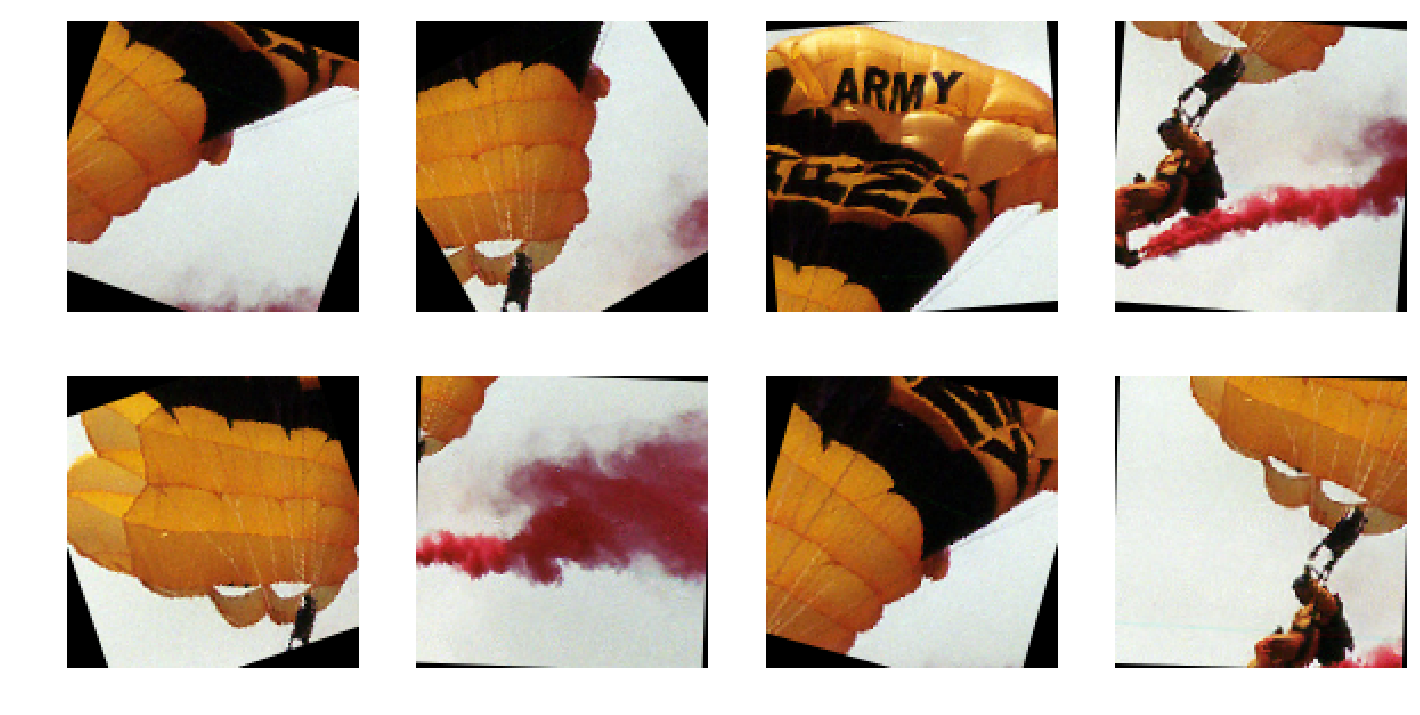

In [128]:
show_batch(tfm_x, rows=2)

Indeed, if you look at the image in the upper left-hand corner, you'll notice that has been rotated to the right! The area inside the original image's upper-left corner is now hidden above the upper border of the output image.

#### Reflection Padding

We can set the `padding_mode` to `'reflection'` to fill in the empty black spaces. Notice that the images are still rotated, but the black triangles in the corners are now filled in with a reflection of the part of the image that borders on each black triangle's hypotenuse.

In [129]:
tfm_x = F.grid_sample(x, tfm_grid, padding_mode='reflection')

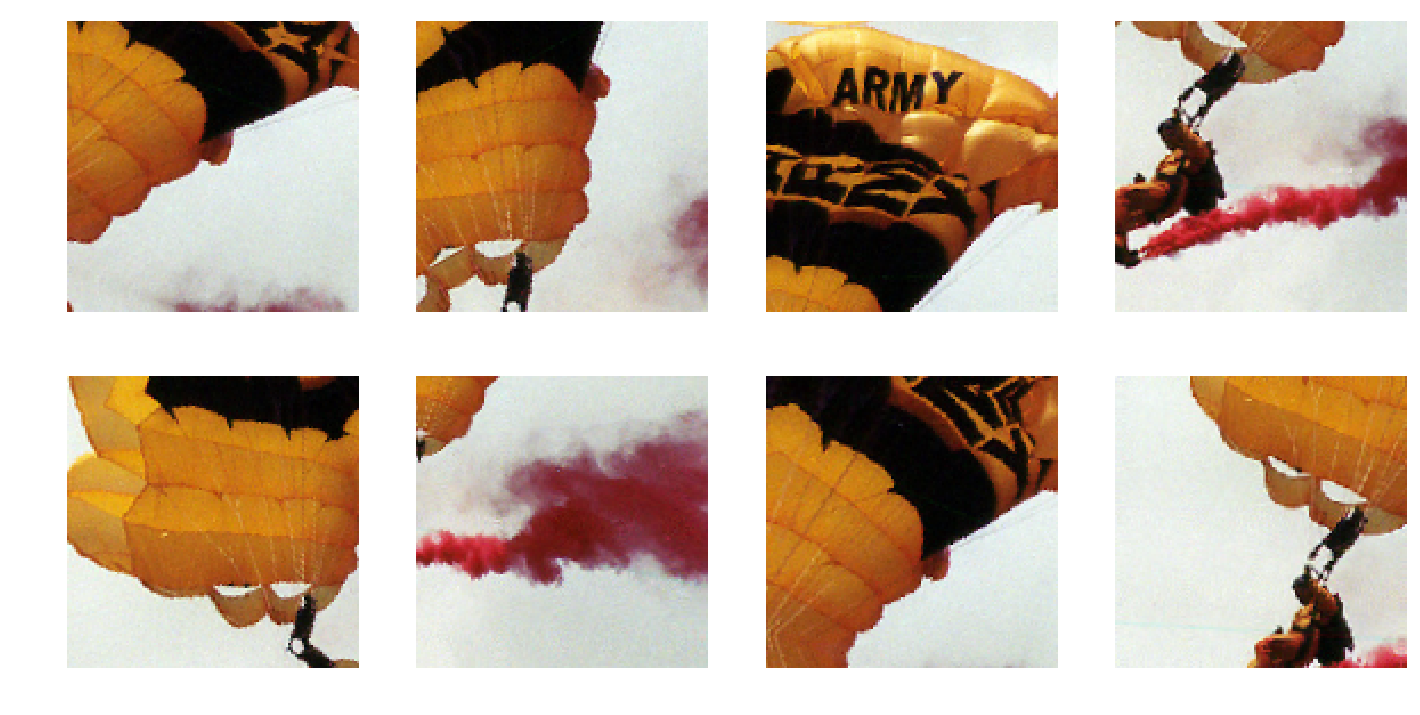

In [130]:
show_batch(tfm_x, rows=2)

### Combine Steps 1-2-3 into a `rotate_batch()` method

In [131]:
def rotate_batch(x, size, degrees):
    grid_map = affine_grid(x, size)
    θs = x.new(x.size(0)).uniform_(-degrees, degrees)
    m = rotation_matrix(θs)
    A = m[:,:2,:2]
    b = m[:,2,:2][:,None]
    grid_map = grid_map.view(64,-1,2)
    tfm_grid = (torch.bmm(grid_map, A) + b).view(-1,128,128,2)
    return F.grid_sample(x, tfm_grid, padding_mode='reflection')

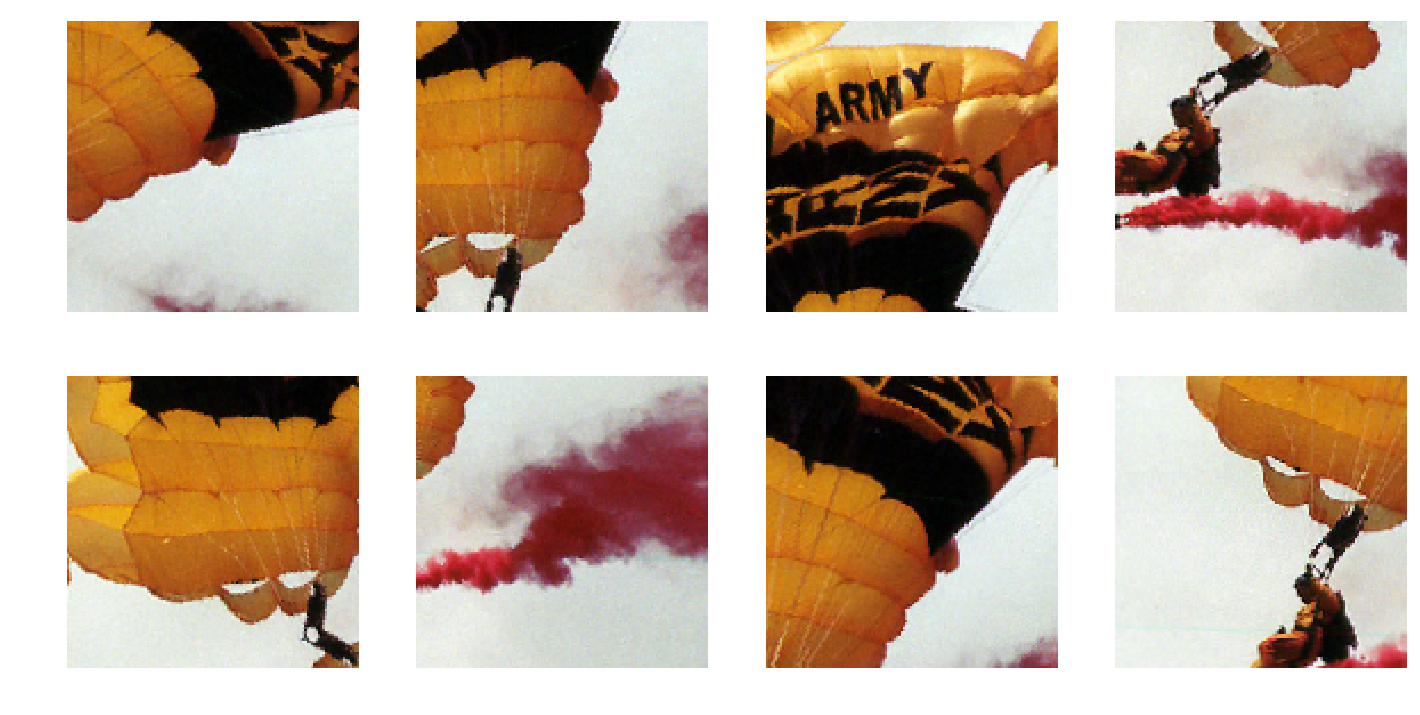

In [132]:
x_rotated = rotate_batch(x, 128, 30)
show_batch(x_rotated, rows=2)

In [133]:
%timeit -n 100 t = rotate_batch(x, 128, 30)

4.99 ms ± 474 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We should be impressed that we can rotate one batch of images in such a short time. This works out to less than 100 µs per image!

### JIT version of `rotate_batch()`

If we use [PyTorch's JIT](https://pytorch.org/docs/stable/jit.html), we can speed things up ever so slightly. As of April 2019, whether or not one will experience JIT's benefits depends largely on the GPU model being used.

On a [V100 GPU](https://www.nvidia.com/en-us/data-center/tesla-v100/) JIT can be 3x faster than a non-JIT PyTorch implementation. However, as we will shortly see, on the [Tesla K80 GPU](https://www.nvidia.com/en-gb/data-center/tesla-k80/) used by my AWS [p2.xlarge instance](https://aws.amazon.com/blogs/aws/new-p2-instance-type-for-amazon-ec2-up-to-16-gpus/), I see only a slight improvement by using JIT.

In [136]:
from torch import Tensor
from torch.jit import script

@script
def JIT_rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    size = (x.size(0), x.size(1)) + (size, size)
    identity_matrix = torch.zeros(2,3, device = x.device)
    identity_matrix[0,0] = 1
    identity_matrix[1,1] = 1
    grid_map = F.affine_grid(identity_matrix.expand(x.size(0), 2, 3), size)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees, degrees)
    m = rotation_matrix(thetas)
    A = m[:,:2,:2].unsqueeze(1)
    b = m[:,2,:2].unsqueeze(1).unsqueeze(2)
    tfm_grid = torch.matmul(grid_map, A) + b
    return F.grid_sample(x, tfm_grid, padding_mode='reflection')

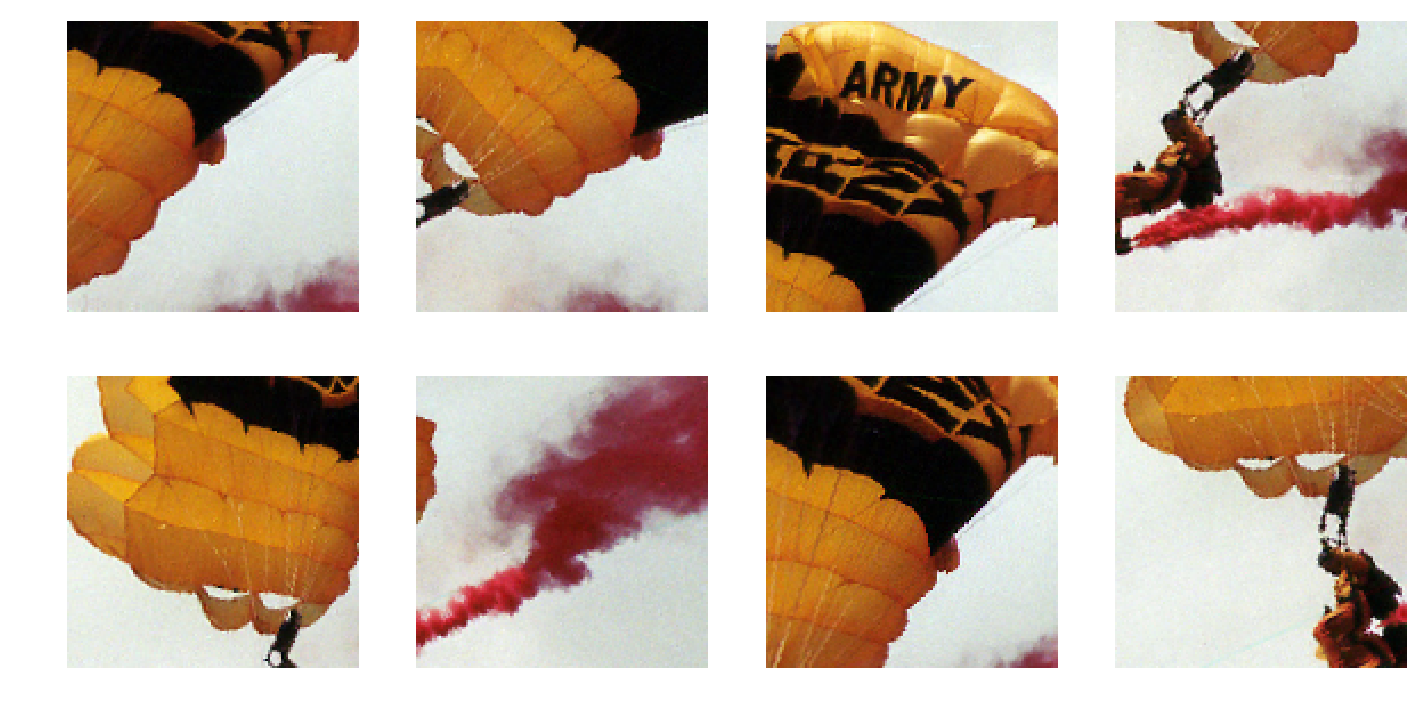

In [137]:
x_rotated = JIT_rotate_batch(x, 128, 30)
show_batch(x_rotated.detach(), rows=2)

In [138]:
%timeit -n 100 t = JIT_rotate_batch(x, 128, 30)

4.38 ms ± 551 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Even faster than JIT: using `F.affine_grid`

We can speed thing up by combining steps 1 and 2 into one operation. Using PyTorch's [`F.affine_grid` function](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.affine_grid), we can create both the grid map and rotation transform grid in one fell swoop! This will speed things up considerably!

In [139]:
def rotate_batch(x, size, degrees):
    size = (size, size) if isinstance(size, int) else tuple(size)
    size = (x.size(0), x.size(1)) + size
    θs = x.new(x.size(0)).uniform_(-degrees, degrees)
    m = rotation_matrix(θs)
    tfm_grid = F.affine_grid(m[:,:2], size)
    return F.grid_sample(x, tfm_grid, padding_mode='reflection')

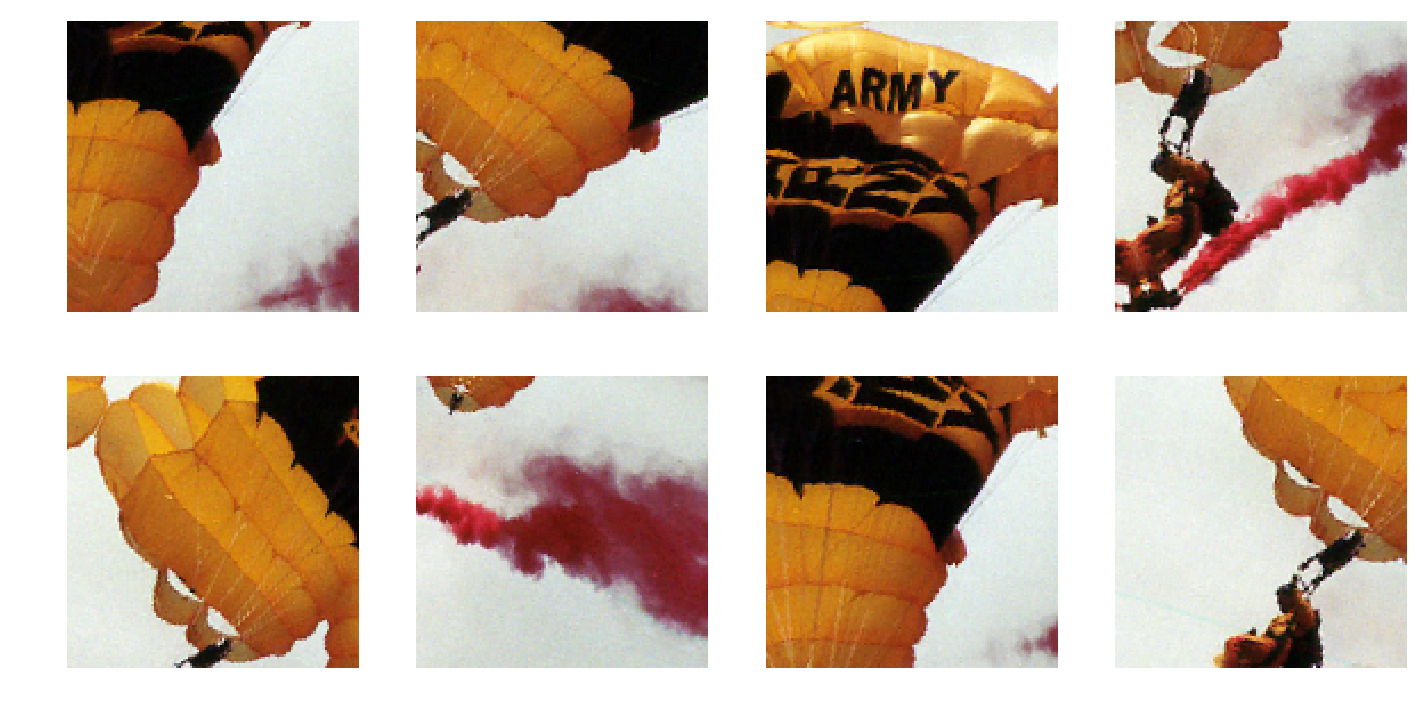

In [140]:
x_rotated = rotate_batch(x, 128, 30)
show_batch(x_rotated, rows=2)

In [141]:
%timeit -n 10 t = rotate_batch(x, 128, 30)

489 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This implementation, clocking in around 500 µs per batch of 64 images, allows us to rotate each image just around 8 µs per image!

### Next: NVIDIA's DALI Batch Image Augmentation Library

Before proceeding onto the [next notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10b_mixup_label_smoothing_my_reimplementation.ipynb?flush_cache=true) of the fast.ai part II coursework, I decided to take a week-long detour to learn how to use [NVIDIA's DALI library](https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/index.html#).

Specifically, I was intrigued by NVIDIA's claims that DALI didn't just cut-down on preprocessing time by allowing image augmentation transforms to be performed in parallel on the GPU, but that it also gave practitioners *flexibility* in customizing these transforms.

[This notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/Diving_into_DALI.ipynb?flush_cache=true) chronicles my exploration determine assess whether I found both of those claims to be true in practice.

### Export

In [96]:
nb_auto_export()

<IPython.core.display.Javascript object>